# Epynet week 0 simulation (custom demand patterns and initial tank conditions)

In [47]:
import sys

# Davide's epynet
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'scripts')

from scripts import network
from scripts import epynetUtils

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#import warnings
#warnings.filterwarnings('ignore')

import csv
import pandas as pd
import yaml
import time
import datetime

import warnings
warnings.filterwarnings('ignore')

In [48]:
net = network.WaterDistributionNetwork("ctown_pd.inp")
demand_patterns_path = '../demand_patterns/three_year_demands_ctown.csv'
starting_demand_path = '../demand_patterns/starting_demand_points.csv'
tank_levels_path = '../demand_patterns/tank_initial_conditions.csv'
simulation_days = 10
week_index = 0

Configure custom demand patterns

In [49]:
step = 300
duration = simulation_days*24*3600
net.set_time_params(duration=duration, hydraulic_step=step) # duration=24h, hydstep=10min

In [50]:
limit = (simulation_days * 24) - 1
total_demands = pd.read_csv(demand_patterns_path, index_col=0)
demand_starting_points = pd.read_csv(starting_demand_path, index_col=0)

In [51]:
net.patterns['DMA1_pat'].values[:5]

[0.5691504, 0.46466868, 0.43854825, 0.3604161, 0.309779115]

In [52]:
week_start = demand_starting_points.iloc[week_index][0]
week_demands = total_demands.loc[week_start:week_start + limit, :]

for pattern_id in net.patterns.uid:
    net.set_demand_pattern(pattern_id, week_demands[pattern_id].values.tolist())

In [53]:
net.patterns['DMA1_pat'].values[:5]

[0.8191877364722848,
 0.6325660034591887,
 0.6341204630791828,
 0.6390756987981645,
 0.5381562327145257]

Configure initial tank levels

In [54]:
initial_tank_levels = pd.read_csv(tank_levels_path, index_col=0)
#todo: Handle exception if there are key errors due to malformed columns in the tank init file
for tank in initial_tank_levels.columns:
    net.tanks[tank].tanklevel = float(initial_tank_levels.iloc[week_index][tank])

In [55]:
net.run(interactive=False)

100%|██████████| 864000/864000 [29:32<00:00, 487.44it/s]  


In [56]:
df_nodes = net.df_nodes_report
tanks_results = df_nodes.iloc[:, df_nodes.columns.get_level_values(2)=='pressure']['tanks']
junctions_results = df_nodes.iloc[:, df_nodes.columns.get_level_values(2)=='pressure']['junctions']

In [57]:
def do_subplot(series, variable_names, variable_type, legends, xlim=None, ylim=None):
    subplot_hspace = 0.6
    subplot_wspace = 0.1
    subplot_y_num = 2
    subplot_x_num = (len(variable_names)/subplot_y_num) + 1    
    i = 0

    for variable in variable_names:
        dd = plt.subplot(subplot_x_num,subplot_y_num,i+1)
        j = 0
        for serie in series:                        
            #serie[variable].plot(label=legends[j], ax=dd)        
            dd.plot(serie[variable][variable_type], label=legends[j])
            j = j + 1

        plt.title(variable_names[i])
        plt.xlabel('Iterations')
        plt.ylabel('tank level (m)')                       
        if xlim:
            plt.xlim(left=xlim[0], right=xlim[1])                    
        if ylim:
            plt.ylim(left=ylim[0], right=ylim[1])            
            
        plt.legend()
        plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
        plt.grid(True)
        
        i = i+1

In [90]:
def plot_results(df, variables):
    ncols = 2
    nrows=(np.ceil(len(variables)/2)).astype(int)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*10, nrows*3))

    for i,ax in enumerate(fig.axes):
        df[variables[i]].plot(ax=ax, label=variables[i])
        ax.legend(fontsize = 12, loc = 2)
        if i == len(variables)-1:
            break

    fig.tight_layout()

In [88]:
tanks_results.columns = tanks_results.columns.droplevel(1)
tanks_results

id,T1,T2,T3,T4,T5,T6,T7
0 days 00:00:00,5.572973,1.343181,2.151762,3.533300,1.501424,1.884450,3.832405
0 days 00:05:00,5.523940,1.312604,2.193601,3.385783,1.535963,1.853217,3.646689
0 days 00:10:00,5.474917,1.282050,2.235387,3.238265,1.570433,1.821678,3.461390
0 days 00:15:00,5.425904,1.251518,2.277120,3.090748,1.604833,1.789834,3.276506
0 days 00:20:00,5.395686,1.232705,2.302823,2.999779,1.626003,1.770012,3.162745
...,...,...,...,...,...,...,...
9 days 23:40:00,3.779888,4.499118,3.674011,3.205816,2.615661,5.304591,2.619313
9 days 23:45:00,3.764985,4.454676,3.641281,3.196890,2.644362,5.317154,2.619062
9 days 23:50:00,3.750096,4.410246,3.608551,3.187926,2.673025,5.329677,2.618838
9 days 23:55:00,3.735222,4.365827,3.575821,3.178925,2.701653,5.342160,2.618641


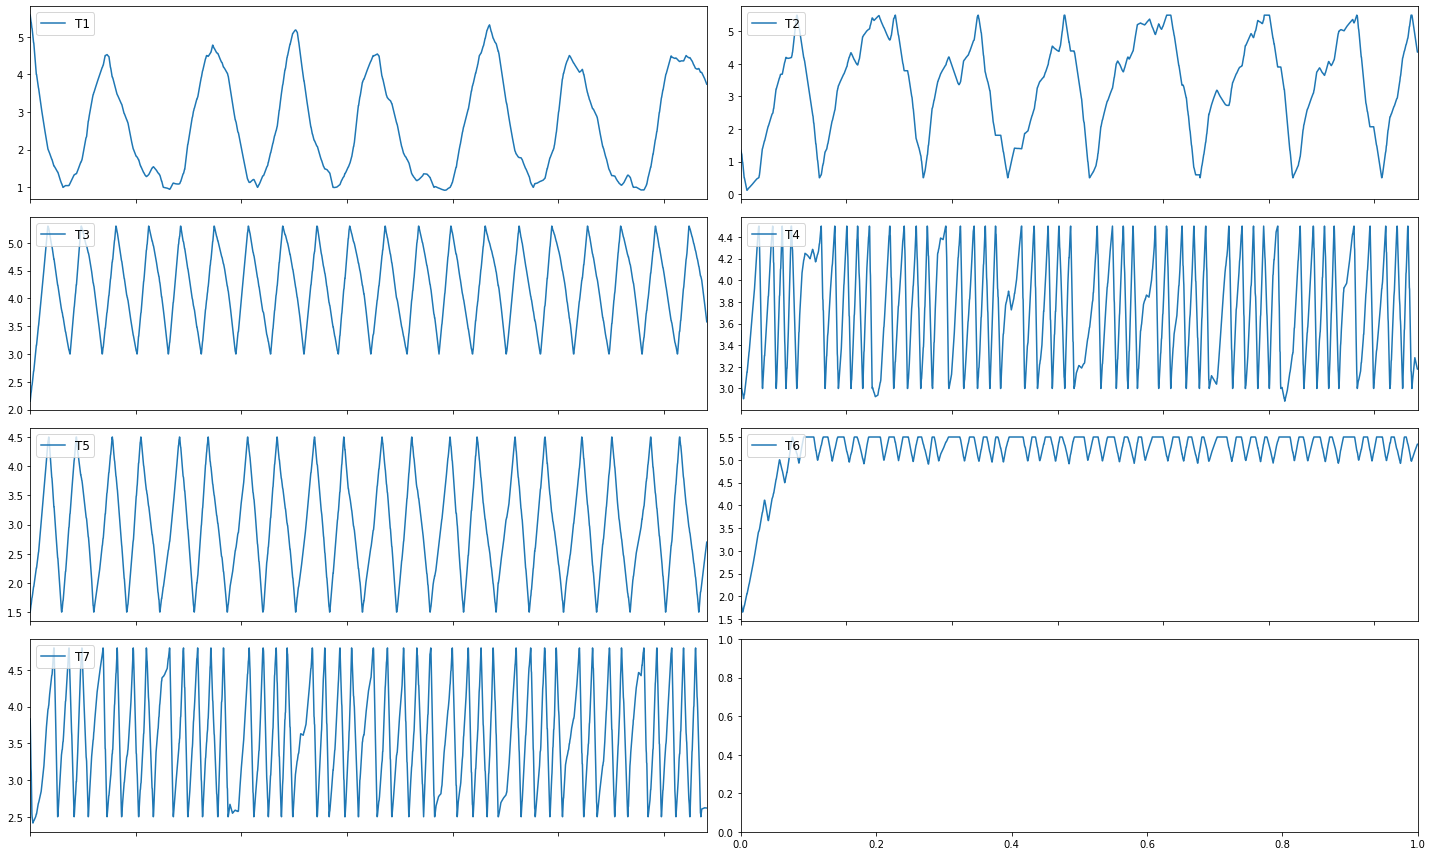

In [91]:
tanks = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'] 
#do_subplot([tanks_results], tanks, 'pressure',['Epynet'])

plot_results(tanks_results, tanks)

In [92]:
junctions_results.columns = junctions_results.columns.droplevel(1)

In [93]:
junctions_csv = pd.read_csv("junctions_results_week.csv", index_col=0)
junctions_csv = junctions_csv.iloc[1:].astype(float)

In [95]:
junctions = ['J310', 'J311', 'J312', 'J313', 'J318', 'J319', 'J219', 'J320', 'J321', 'J322', 'J324', 
'J327', 'J328', 'J329', 'J50', 'J330', 'J331', 'J231', 'J232', 'J1170', 'J348', 'J349',
'J78', 'J351', 'J352', 'J353', 'J354', 'J355', 'J358', 'J359', 'J82', 'J83', 'J84', 'J360',
'J361', 'J362', 'J1208', 'J381', 'J382', 'J384', 'J295', 'J296', 'J303', 'J305', 'J267', 
'J268', 'J52', 'J230', 'J235', 'J317', 'J323']

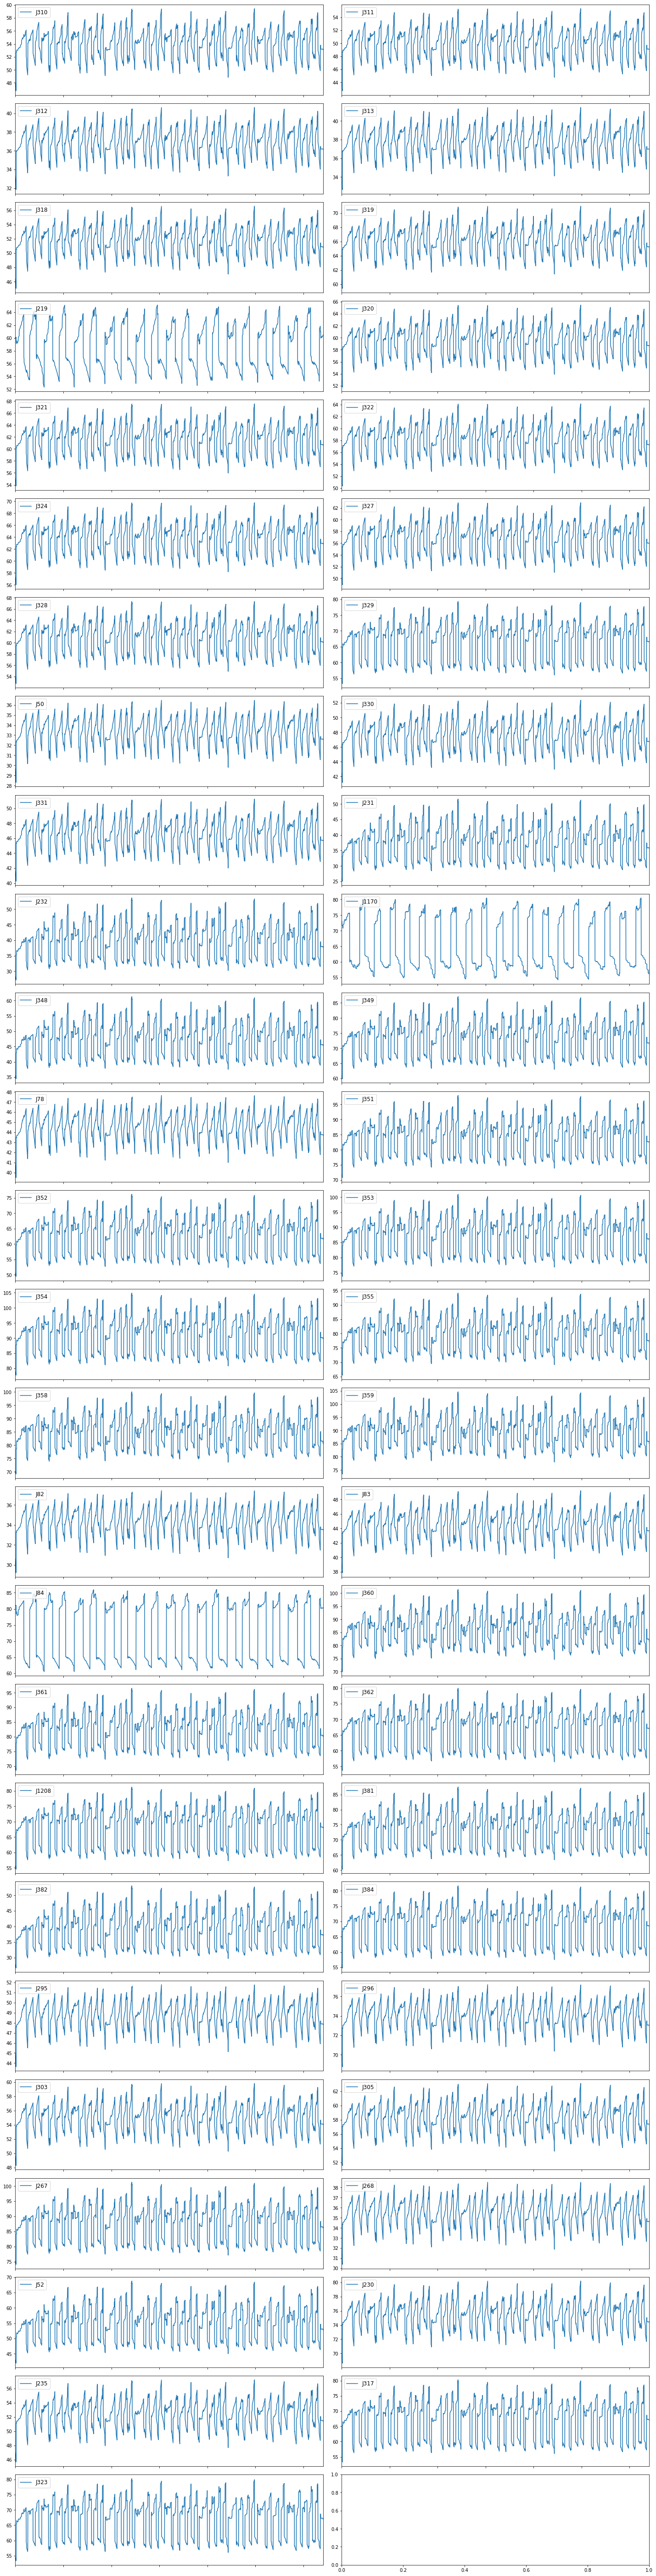

In [97]:
plot_results(junctions_results, junctions)